In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2]:
pipelines_reg = {
    'SVR': Pipeline([('scaler', StandardScaler()), ('reg', SVR())]),
    'DT': Pipeline([('scaler', StandardScaler()), ('reg', DecisionTreeRegressor())]),
    'LR': Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())]),
    'RF': Pipeline([('scaler', StandardScaler()), ('reg', RandomForestRegressor())])
}

param_grids_reg = {
    'SVR': {
        'reg__C': [0.1, 1, 10],
        'reg__kernel': ['rbf', 'linear'],
        'reg__epsilon': [0.01, 0.1, 0.5]
    },
    'DT': {
        'reg__max_depth': [None, 3, 5, 7],
        'reg__min_samples_split': [2, 5, 10],
        'reg__min_samples_leaf': [1, 2, 4]
    },
    'LR': {
        'reg__fit_intercept': [True, False]
    },
    'RF': {
        'reg__n_estimators': [50, 100, 200],
        'reg__max_depth': [None, 5, 10],
        'reg__min_samples_split': [2, 5, 10]
    }
}

In [3]:
results_reg = []
best_reg_models = {}

for name, pipeline in pipelines_reg.items():
    grid = GridSearchCV(pipeline, param_grids_reg[name], cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_reg_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    
    results_reg.append({
        'Algorithm': name,
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Best Params': grid.best_params_
    })

results_df_reg = pd.DataFrame(results_reg)
results_df_reg

,Algorithm,MSE,MAE,R2,Best Params
0,SVR,2910.731438,42.529921,0.460807,"{'reg__C': 10, 'reg__epsilon': 0.5, 'reg__kern..."
1,DT,3616.769895,46.957630,0.330018,"{'reg__max_depth': 3, 'reg__min_samples_leaf':..."
2,LR,2821.750981,41.919378,0.477290,{'reg__fit_intercept': True}
3,RF,2862.175781,42.939003,0.469801,"{'reg__max_depth': 5, 'reg__min_samples_split'..."


In [5]:
best_row = results_df_reg.loc[results_df_reg['R2'].idxmax()]
best_algo_name = best_row['Algorithm']
best_regressor = best_reg_models[best_algo_name]


joblib.dump(best_regressor, 'best_regressor.joblib')


loaded_reg = joblib.load('best_regressor.joblib')
sample_preds_orig = best_regressor.predict(X_test[:5])
sample_preds_load = loaded_reg.predict(X_test[:5])

print(f"Best Model: {best_algo_name}")
print("Original preds:", sample_preds_orig)
print("Loaded preds:  ", sample_preds_load)

Best Model: LR
Original preds: [138.46970031 181.10052342 125.34400904 292.75977277 123.8830531 ]
Loaded preds:   [138.46970031 181.10052342 125.34400904 292.75977277 123.8830531 ]


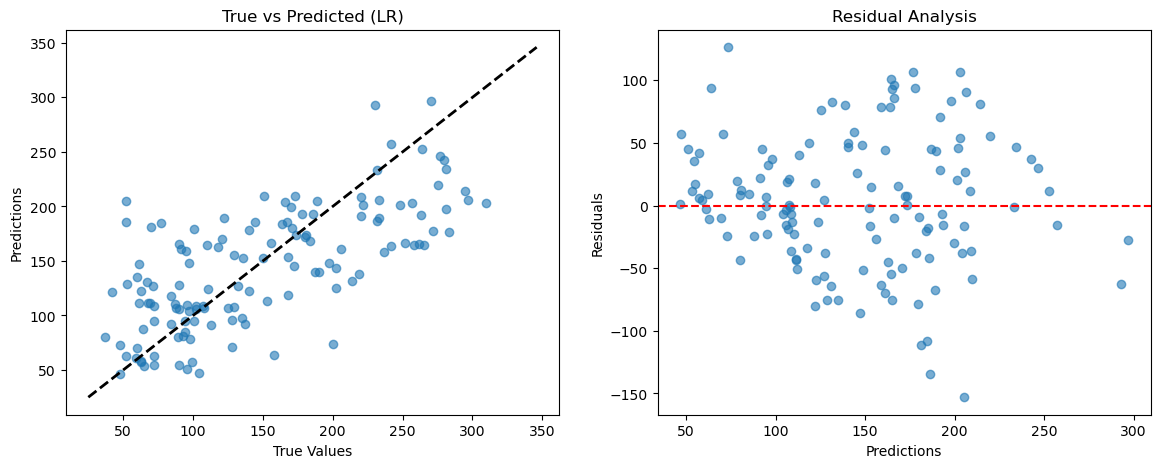

In [6]:
y_pred_best = best_regressor.predict(X_test)
residuals = y_test - y_pred_best

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(y_test, y_pred_best, alpha=0.6)
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predictions')
ax[0].set_title(f'True vs Predicted ({best_algo_name})')

ax[1].scatter(y_pred_best, residuals, alpha=0.6)
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].set_xlabel('Predictions')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residual Analysis')

plt.show()